## Spatial interpolation for EPA AQI

Last updated on 07/06/2023


This notebook demonstrates the spatial interpolation of the EPA real-time air quality monitoring data from AirNow API: https://docs.airnowapi.org/

User-defined variables

In [33]:
# Data csv file
infile = 'drive/MyDrive/epa_chicago_20230626.csv'
# Grid and domainfile
gridfile = 'drive/MyDrive/grid.pkl'

## Google Colab Environment

In [34]:
pip install ipyleaflet

In [35]:
pip install gpcam

In [36]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load Data

In [37]:
import pandas as pd
import pickle

In [38]:
df = pd.read_csv(infile)

In [39]:
f = open(gridfile,"rb")
grid = pickle.load(f)
f.close()

## Map Visualization

In [40]:
from ipyleaflet import Map
from ipyleaflet import basemaps
from ipyleaflet import (Map, basemaps, WidgetControl, GeoJSON,
                        LayersControl, Icon, Marker,FullScreenControl,
                        CircleMarker, Popup, AwesomeIcon)
from ipywidgets import HTML
import matplotlib.pyplot as plt
import matplotlib as mpl

In [41]:
def plotmapAQI(metric,df,center,zoom):
    df = df.reindex(columns = df.columns.tolist()+ ['color'])
    # Determine color depending on the values
    color=[]
    # Scaling the values
    for (i,j) in df.iterrows():
        value=j[metric]
        if value<=50:
            color.append('green')
        elif(value>50 and value<=100):
            color.append('yellow')
        elif(value>100 and value<=150):
            color.append('orange')
        elif(value>150 and value<=200):
            color.append('red')
        else:
            color.append('darkred')
    df['color']=color
    # Map
    center = center
    zoom = zoom
    i=0
    m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
    # Add markers
    for (index,row) in df.iterrows():
        loc = [row.loc['Latitude'],row.loc['Longitude']]
        #icon = AwesomeIcon(
        #         marker_color='red')
        # marker = Marker(location=loc, icon, draggable=False,alt='alt')
        # marker.color = 'red'
        marker = CircleMarker()
        marker.location = loc
        marker.radius = 5
        marker.color = row.loc['color']
        marker.fill_color = row.loc['color']

        m.add_layer(marker);
        # Pop up
        message = HTML()
        message.value = 'Location:'+str(row.loc['Latitude'])+','+str(row.loc['Longitude'])+', Value:'+str(row.loc[metric])
        marker.popup = message

        i+=1
    m.add_control(FullScreenControl())
    mpl.rcParams.update({'font.size': 10})
    fig=plt.figure(figsize=(8,3))
    ax=fig.add_subplot(111)
    vals=[]
    for i in range(6):
        vals.append((((250)/5)*i)+0)
    cmap = mpl.colors.ListedColormap(['green','yellow','orange','red','darkred'])
    norm = mpl.colors.BoundaryNorm(vals, cmap.N)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
    cb.set_label(metric)
    ax.set_position((0.1, 0.45, 0.8, 0.1))
    return m

Map(center=[42.8172225, -87.39416800000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

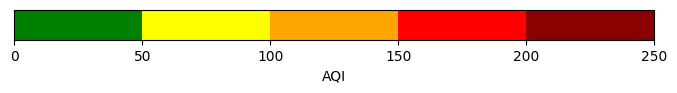

In [42]:
metric = "AQI"
plotmapAQI(metric,df,grid['center'],7)

## Interpolation by GPCAM

In [43]:
import gpcam
from gpcam.autonomous_experimenter import AutonomousExperimenterGP
from gpcam.gp_optimizer import GPOptimizer

import numpy as np

In [44]:
# Define the kernel/covariance
def kernel_RBF_noise(x1, x2, hps, obj):
    var = hps[0]
    noise_var = hps[3]
    d1 = abs(np.subtract.outer(x1[:, 0], x2[:, 0]))
    d2 = abs(np.subtract.outer(x1[:, 1], x2[:, 1]))
    d = ((d1/hps[1])**2 + (d2/hps[2])**2)**0.5
    K = var * np.exp(-d ** 2)
    if x1 is x2:
        return K + noise_var * np.eye(K.shape[0])
    else:
        return K

In [54]:
# Training data: locations (latitude, longitude) and AQI values at the sensor locations
x_train = np.column_stack((np.array(df['Latitude']),np.array(df['Longitude'])))
y_train = np.array(df['AQI'])

# Range of coordinates
param_bounds = np.array([[x_train[:,0].min(), x_train[:,0].max()],
                [x_train[:,1].min(), x_train[:,1].max()]])
# Initial hyperparameter values
init_hp = np.array([np.var(y_train),1.,1., np.var(y_train)*0.01])

# Range of hyperparameters
hp_bounds = np.array([[np.var(y_train)*0.7,np.var(y_train)*1.3],[0.5,2.0],[0.5,2.0],[np.var(y_train)*0.01,np.var(y_train)*0.1]])

In [55]:
# Run GP (Maximul likelihood esitmation)
my_ae = AutonomousExperimenterGP(param_bounds,
                                 init_hp,
                                 hp_bounds,
                                 init_dataset_size= 100,
                                 x_data=x_train,
                                 y_data=y_train,
                                 kernel_func = kernel_RBF_noise,
                                 use_inv = True,
                                 communicate_full_dataset = False,
                                 ram_economy = False)#, info = False, prior_mean_func = optional_mean_func)
my_ae.train(max_iter=10000)

In [56]:
# Estimated hyperparameters
my_ae.gp_optimizer.hyperparameters

array([455.49797222,   1.06463311,   1.24364078,  35.03830556])

In [57]:
# Estimate the mean and variance at all the grid locations
xx = np.column_stack((grid['xx0'].flatten(),grid['xx1'].flatten()))
f = my_ae.gp_optimizer.posterior_mean(xx)["f(x)"].reshape(grid['n_pts'])
v = my_ae.gp_optimizer.posterior_covariance(xx)["v(x)"].reshape(grid['n_pts'])

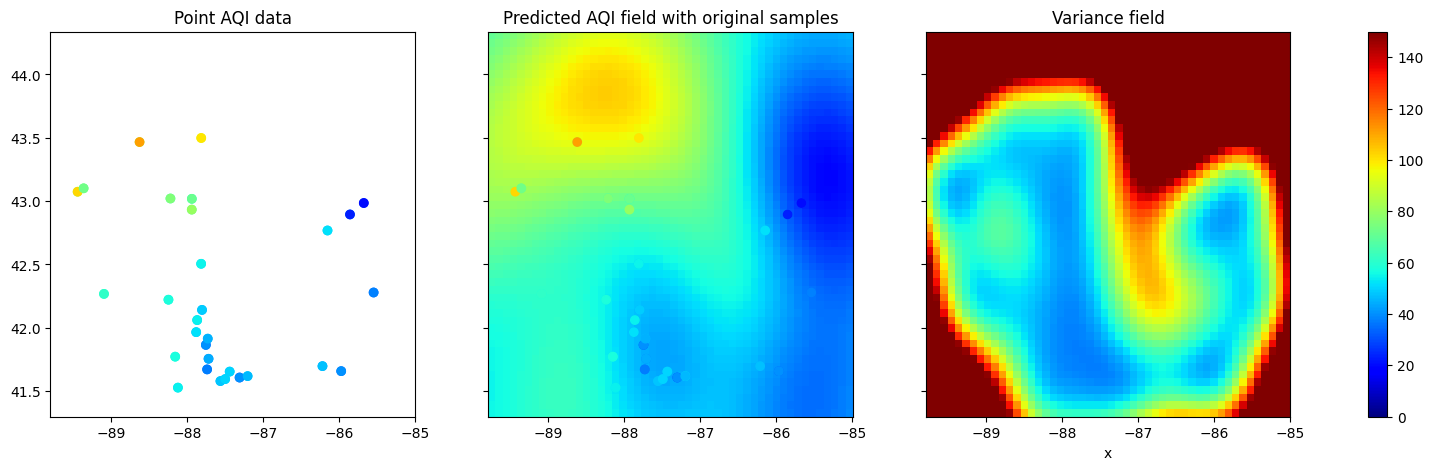

In [63]:
# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharex=True, sharey=True)

# Original values
axs[0].scatter(x_train[:,1], x_train[:,0], c=y_train, cmap="jet",vmin=0,vmax=150)
axs[0].set_title(f'Point AQI data')

# Predicted value field
s1 = axs[1].pcolormesh(grid['xx1'], grid['xx0'], f, cmap="jet",vmin=0,vmax=150)
axs[1].scatter(x_train[:, 1], x_train[:, 0], c=y_train, cmap="jet",vmin=0,vmax=150)
axs[1].set_title(f'Predicted AQI field with original samples')

# Variance field
s2 = axs[2].pcolormesh(grid['xx1'], grid['xx0'], v, cmap="jet",vmin=0,vmax=150)
axs[2].set_title(f'Variance field')
axs[2].set_xlabel('x')

# Create a single colorbar for all subplots
fig.colorbar(s1, ax=axs)  # Adjust the 'pad' parameter to change the spacing between plots and colorbar

plt.show()

## Overlay with Map

In [64]:
from base64 import b64encode
from io import StringIO, BytesIO
import PIL
from ipyleaflet import Map, ImageOverlay

In [65]:
# Convert the mean field to a image for overlay
def image2map(f,vmin,vmax):
  # Scale the field between vmin and vmax
  f = (f-vmin)/(vmax-vmin)
  f = np.transpose(f)
  f = np.flipud(f)
  # Define the image
  f_im = PIL.Image.fromarray(np.uint8(plt.cm.jet(f) * 255))
  im = PIL.Image.new("RGBA", f.shape, color=None)
  im.paste(f_im)
  fio = BytesIO()
  # Image to URL
  im.save(fio, "png")
  data = b64encode(fio.getvalue())
  data = data.decode("ascii")
  return "data:image/png;base64," + data

In [66]:
imgurl = image2map(f,0,150)

In [67]:
m = Map(center=grid['center'], zoom=7)
image = ImageOverlay(
    url=imgurl,
    bounds=((grid['sw'][0],grid['sw'][1]), (grid['ne'][0],grid['ne'][1])),
    opacity=0.3
)

m.add_layer(image);
m

Map(center=[42.8172225, -87.39416800000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…